# Pathway analysis with scBonita


## To perform pathway analysis, scBONITA uses the rules generated in Step 2. 

In addition, scBONITA requires:

* a **metadata file** specifiying the treatments/experimental variables for each cell and 
* a **contrast file** specifying the pairs of treatments to be compared.


## The pathway analysis script has the following arguments:

* **dataFile** 
    
    Specify the name of the file containing processed scRNA-seq data


* **conditions**
    
    Specify the name of the file containing cell-wise condition labels, ie, metadata for each cell in the training dataset. The columns are condition variables and the rows are cells. The first column must be cell names that correspond to the columns in the training data file. The column names must contain the variables specified in the contrast file (see contrast --help for more information).


* **contrast**
    
    A text file where each line contains the two conditions (corresponding to column labels in the conditions file) are to be compared during pathway analysis.


* **conditions_separator**
    
    Separator for the conditions file. Must be one of 'comma', 'space' or 'tab' (spell out words, escape characters will not work).",


* **contrast_separator**
    
    Separator for the contrast file. Must be one of 'comma', 'space' or 'tab' (spell out words, escape characters will not work).",

* **pathwayList**

    Paths to GRAPHML files that should be used for scBONITA analysis. Usually networks from non-KEGG sources, saved in GRAPHML format. The default value is to use sll the networks initially used for rule inference.
   

## Example usage with the provided example files in the `data` folder:

> `python3.6 pathwayAnalysis.py --dataFile "data/trainingData.csv" --conditions "data/conditions.txt" --contrast "data/contrast.txt" --conditions_separator "comma" --contrast_separator "comma" --pathwayList "hsa00010"`

## Output files from scBONITA Pathway Analysis

1. A comma-separated (CSV) file named as

> **pvalues + contrast[0] + _vs_ + contrast[1] + .csv**

For example, if the conditions to be compared (and specified in the contrasts file) are 'control' and 'treatment', the output file of scBONITA pathway analysis will be:

> **pvalues_control_vs_treatment.csv**

2. For each network, a file ending in **_importanceScores.csv**

This file contains a table with the following columns:

* **Node**: Gene name
* **Importance Score**: Importance score for the node in the network, calculated using the provided training dataset
* **ObsERS**: Observed size of the equivalent rule set or ERS. This is the number of possible equally valid Boolean rules for this node.
* **MaxERS**: Maximum possible size of the ERS for that node. This is (2^n) - 1, where n is the number of incoming edges for the node in the network.
* Two columns named as the two conditions to be compared/specified in the contrast file: the expression of the cells in those two conditions
* **Upregulated_in_condition** A boolean column stating whethere the node is up regulated in 'condition'

3. For each network, a GRAPHML file ending in "_IS" with node attributes similar to the ones in the importance scores CSV

## View and analyze the output of scBONITA

#### Load required packages

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from singleCell import *

#### Example pvalues file

In [19]:
pvalues = pd.read_csv("data/pvalues_Control_vs_Treatment.csv")
pvalues.head()

,Pathway ID,Pathway Name,P value,Contrast,Upregulated_in_Control,Adjusted P value
0,data/hsa00010,data/hsa00010,0.158147,Control_vs_Treatment,False,0.158147


#### Make bubbleplots using generated pvalues

In [23]:
from singleCell import *
singleCell.makeBubblePlots(pd.read_csv("data/pvalues_Control_vs_Treatment.csv"),
                    adjPValueThreshold=1,
                    wrap=25,
                    height=8,
                    width=10,
                    palette="colorblind",
                    saveAsPDF=True,
                    outputFile="example_PA_bubbleplot.pdf")

ValueError: Could not interpret value `log10pvals` for parameter `x`

#### Example importance scores file

In [24]:
importanceScores = pd.read_csv("data/hsa00010.graphml_processed.graphml_importanceScores.csv")
importanceScores.head()

,Node,Importance Score,ObsERS,MaxERS,Control,Treatment,Upregulated_in_Control
0,DLAT,0.003994,127,127,0.012987,0.043478,False
1,GALM,0.881890,16,127,0.038961,0.043478,False
2,DLD,0.003994,127,127,0.116883,0.260870,False
3,BPGM,0.463312,12,127,0.025974,0.043478,False
4,MINPP1,0.362319,3,7,0.000000,0.000000,False


#### Plot the equivalent rule set sizes for this network

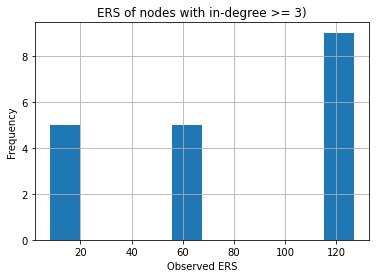

<Figure size 432x288 with 0 Axes>

In [25]:
importanceScores.loc[importanceScores["MaxERS"] == 127].hist(column='ObsERS')
plt.xlabel('Observed ERS')
plt.ylabel('Frequency')
plt.title('ERS of nodes with in-degree >= 3)')
plt.show()
plt.clf()

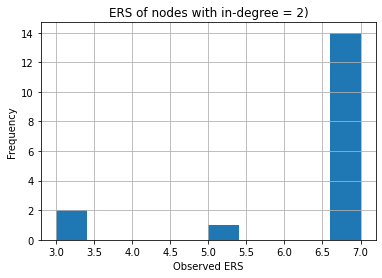

<Figure size 432x288 with 0 Axes>

In [26]:
importanceScores.loc[importanceScores["MaxERS"] == 7].hist(column='ObsERS')
plt.xlabel('Observed ERS')
plt.ylabel('Frequency')
plt.title('ERS of nodes with in-degree = 2)')
plt.show()
plt.clf()

#### Visualize the output network in external software such as CytoScape or Gephi

In [27]:
graph = nx.read_graphml("data/hsa00010_IS_Control_vs_Treatment.graphml")

In [31]:
pd.DataFrame.from_dict(dict(graph.nodes(data=True)), orient='index')

,0,1,2
0,DLAT,DLD,"{'color': 'purple', 'subtype': 'compound', 'ty..."
1,DLAT,POR,{'signal': 'a'}
2,GALM,ADPGK,"{'color': 'purple', 'subtype': 'compound', 'ty..."
3,GALM,HK1,{'signal': 'a'}
4,GALM,HK2,{'signal': 'a'}
...,...,...,...
117,ACSS1,ALDH2,{'signal': 'a'}
118,ACSS1,ALDH1B1,{'signal': 'a'}
119,ACSS1,ALDH9A1,{'signal': 'a'}
120,ACSS1,ALDH3A2,{'signal': 'a'}


In [32]:
pd.DataFrame.from_dict(graph.edges(data=True))

,name,type,importanceScore,Observed ERS,Max ERS,relativeAbundance,Control,Treatment,Upregulated_in_Control
DLAT,DLAT,gene,0.003994,127,127,-0.030491,0.012987,0.043478,False
GALM,GALM,gene,0.881890,16,16,-0.004517,0.038961,0.043478,False
DLD,DLD,gene,0.003994,127,127,-0.143986,0.116883,0.260870,False
BPGM,BPGM,gene,0.463312,12,12,-0.017504,0.025974,0.043478,False
MINPP1,MINPP1,gene,0.362319,3,3,0.000000,0.000000,0.000000,False
AKR1A1,AKR1A1,gene,0.003994,127,127,0.124788,0.298701,0.173913,True
TPI1,TPI1,gene,0.000000,7,7,0.009599,0.792208,0.782609,True
GPI,GPI,gene,0.335502,16,16,0.107849,0.194805,0.086957,True
ADPGK,ADPGK,gene,1.000000,1,1,0.042349,0.259740,0.217391,True
ALDH9A1,NaN,NaN,0.072464,7,7,-0.039526,0.090909,0.130435,False
